# 水曜日のレクチャーのおさらい
パワーポイントで説明します( ･ิω･ิ)

# アーキテクチャ
パワーポイントで説明します( ･ิω･ิ)

# SOMの求めるもの
- 参照ベクトル
- 勝者ノード

# アルゴリズム
ホワイトボードで説明します( ･ิω･ิ)

# 実装の解説&演習

## 準備

必要なライブラリのインポート

In [8]:
import numpy as np

おまじない（乱数のシード値を固定）

In [9]:
seed = 10
np.random.seed(seed)

### 観測データの作成  
ここでは人工的に作成したデータを観測データとして演習を進める  

| 数式上での記号　　　　| プログラム上での変数名　　　　 | 役割 |
|:-------------------|:----------------------------|:------------|
|$N$|samples_num|サンプル数|
|$D$|observed_dim|観測空間の次元|
|$\mathbf{x}_n\ (n=1,\dots,N)$|X|観測データ．$N$個の$D$次元ベクトルをまとめた$N\times D$の2次元配列になる|
以下を実行してみてください

In [10]:
observed_dim = 3
samples_num = 300

#0で埋めた配列を用意
X=np.zeros((samples_num,observed_dim))

for n in range(samples_num):
  X[n,0]=np.random.rand()*2.0-1.0
  X[n,1]=np.random.rand()*2.0-1.0
  X[n,2]=X[n,0]**2-X[n,1]**2

サイズを見てみよう

In [11]:
X.shape

(300, 3)

300×3の2次元配列になっている．1次元目の300がデータ数，2次元目の3がデータの次元を表す．

 #### 作ったデータを見てみよう！！
 
 描画用のライブラリをインポート　＋　おまじない

In [12]:
%matplotlib inline
# %matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as axes3d

じゃあ、描画してみよう！

(-1.0961287719704085, 1.0895693266045632)

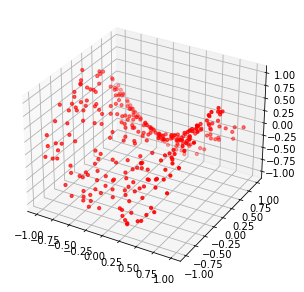

In [14]:
# キャンパスの作成
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# プロットぉぉぉぉ
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c='red', s=10)

# 描画範囲の設定
# ax.set_aspect('equal')
ax.set_xlim(X[:, 0:3].min() * 1.1, X[:, 0:3].max() * 1.1)
ax.set_ylim(X[:, 0:3].min() * 1.1, X[:, 0:3].max() * 1.1)
ax.set_zlim(X[:, 0:3].min() * 1.1, X[:, 0:3].max() * 1.1)

ええ感じのデータができた！ヤッタ！！(๑´ㅂ`๑)

### パラメータの決定

#### 潜在空間に関するパラメータ



| 数式上での記号　　　　　 | プログラム上での変数名　　　　 | 役割 |
|:-------------------:|:----------------------------|:------------|
|$L$|latent_dim|潜在空間の次元数 |
|$K_1$|nodes_row_num|潜在空間の横の1辺あたりのノード数|
|$K_2$|nodes_col_num|潜在空間の縦の1辺あたりのノード数|
|$K$|nodes_num|総ノード数．$L=2$の場合は$K=K_1\times K_2$となる|

In [15]:
latent_dim = 2
nodes_row_num = 10
nodes_col_num = 10
nodes_num = nodes_col_num * nodes_row_num

#### 近傍半径のスケジューリングに関するパラメータ 
これらはSOMの学習に大きな影響を及ぼすので，演習後にレポートで色々試してみてください．


| 数式上での記号　　　　 | プログラム上での変数名　　　 | 役割 |
|:-------------------|:----------------------------|:------------|
|$\sigma_\mathrm{max}$|sigma_max|近傍半径の最大値 |
|$\sigma_\mathrm{min}$|sigma_min|近傍半径の最小値|
|$T$|epoch_num|学習回数|


In [16]:
sigma_max = 1.2
sigma_min = 0.2
epoch_num = 100

### 配列の用意

|数式上での記号| プログラム上での変数名　| 役割　　 |
|:-------------:|:-----------------------|:------------|
|$\mathbf{y}_k\ (k=1,\dots,K)$|Y|参照ベクトル．$K$個の$D$次元ベクトルをまとめた$K\times D$の2次元配列|
|${\boldsymbol \zeta}_k\ (k=1,\dots,K)$|Zeta|潜在空間のノード座標．$K$個の$L$次元配列をまとめた$K\times L$の2次元配列|
|$k_n^*\ (n=1,\dots,N)$|BMU|勝者ノード番号をまとめたサイズ$N$の1次元配列（Best Matching Unit）|
|$h_{kn}\ (k=1,\dots,K,n=1,\dots,N)$|H|$K$個のノードと$N$個の勝者ノードの組み合わせに対する学習量をまとめた$K\times N$の2次元配列|


In [17]:
Y = np.zeros((nodes_num,observed_dim))
Zeta=np.zeros((nodes_num,latent_dim))
BMU=np.zeros(samples_num)
H=np.zeros((nodes_num,samples_num))

## Step 0. 初期化
参照ベクトルを初期化！٩( ´ᆺ｀)۶  
ランダムな値を入れるよ

In [18]:
Y = np.random.rand(nodes_num,observed_dim)*2.0-1.0

## Step 1. 競合過程（Competitive Process）
競合過程では，観測データに対して最も近い参照ベクトルに対応するノード番号を求める  
競合過程では２つの大きな処理が必要だよ  
全ての観測データ $\mathbf{x}_n(n=1,... ,N)$に対して  
- $n$番目の観測データ$\mathbf{x}_n$と$k$番目の参照ベクトル$\mathbf{y}_k$との距離$\|\mathbf{x}_n-\mathbf{y}_k\|^2$を計算する  
- 最も距離の近い参照ベクトルに対応するノード番号$k_{n}^{*}$を求める  

### 2つのベクトルの間の距離を求めてみよう！
>**ユークリッド距離の定義**  
2つのベクトル $\mathbf{x}=\left(x_{1},x_{2},... ,x_{D}\right)$, $\mathbf{y}=\left(y_{1},y_{2},... ,y_{D}\right)$が与えられたときユークリッド距離$D(\mathbf{x},\mathbf{y})$は  
$D(\mathbf{x},\mathbf{y})=\sqrt{(x_{1}-y_{1})^2+(x_{2}-y_{2})^2...+(x_{D}-y_{D})^2}$  
数式の解説はホワイトボードで


2つのベクトル $\mathbf{x}$と$\mathbf{y}$が3次元ベクトルの時のユークリッド距離を求めるプログラム

In [19]:
# 2つの3次元ベクトルa,b
x = np.array([1.0, 2.0, 3.0])
y = np.array([4.0, 5.0, 6.0])

In [20]:
# 距離の計算！
distance = 0
for d in range(x.shape[0]):
  distance = distance + (x[d] - y[d])*(x[d] - y[d])   # D回ループするよ

  
print(distance)

27.0


### 最も距離の近い参照ベクトルの番号($k_{n}^{*}$)を求めよう!!

- numpy(pythonの配列演算用のライブラリ)にはargmin関数がある
- argmin関数を使って最も距離の近い参照ベクトルの番号を求めてみよう

### *argmin関数を使ってみよう!*
2次元配列aからargmin関数を使って各行ごとに値の最小となる配列の番号を求める

In [21]:
a=np.array([[ 3.0,  3.0,  0.0],
       [ 0.0,  5.0,  4.0],
       [ 8.0,  0.0,  1.0],
       [ 1.0,  5.0,  6.0]])


In [22]:
print(np.argmin(a,axis=0))
#axis=0の場合は行に関しての最小値を見ていく。(縦方向に見てその最小値のインデックスをとってくるので出力としては要素数3の1次元配列となる)

[1 2 0]


## *競合過程を実装してみよう! *
2つのベクトルの距離を求めるプログラムとargmin関数を使うことで競合過程は実装できるよ!!

実装に必要なもの  
- 観測データの配列$\mathbf{X}$  
- 参照ベクトルの配列$\mathbf{Y}$

## step2. 協調過程(Cooperative Process)
- 協調過程では**学習量**を求めます．  
- 学習量は，各参照ベクトル$\mathbf{y}_{k}\left(k=1, ..., K\right)$が各観測データ$\mathbf{x}_{n} \left(n=1, ..., N\right)$にどれだけ近づくかを表す量のことです．  
- 学習量は潜在空間上での距離を元に計算します!
学習量は  
- 学習量は勝者ノード${\boldsymbol \zeta}_{k_{n}^{*}}$が一番大きく学習するよ!  
- 勝者ノード(競合過程で求めた参照ベクトルの番号に対応するノード)${\boldsymbol \zeta}_{k_{n}^{*}}$から離れていくほど学習量は少なくなっていきます!!

協調過程では大きく2つの処理が必要!!  
全ての勝者ノード$\boldsymbol {\zeta}_{k_{n}^{*}}(n=1,... ,N)$に対して  
- 勝者ノードとノードの距離を求める
- その距離を元にガウス関数を使って学習量を計算する

### *各ノードの座標を作ってみよう!!*
- 各ノードの座標(2次元)を表す2次元配列を作ってみよう  
※潜在空間の形は様々な形にできます．今回は正方形を作っていきます  
※難しい関数を色々使いますがとりあえずおまじないで大丈夫！

In [23]:
zetax=np.linspace(-1,1,nodes_row_num)
zetay=np.linspace(-1,1,nodes_col_num)
xx,yy=np.meshgrid(zetax,zetay)#meshgrid関数･･･zetaxとzetayの組み合わせを作る関数(xx:zetax:nodes_row_num*nodes_col_num,yy=nodes_row_num*nodes_col_num)
xx=np.ravel(xx)#ravel関数･･･2次元配列を1次元配列に変換する
yy=np.ravel(yy)
Zeta=np.c_[xx,yy]#c_･･･xxとyyを統合

作ったノードを描画してみる

(100, 2)


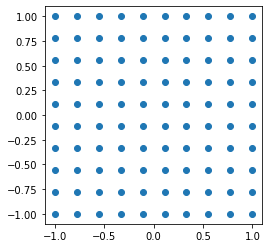

In [24]:
print(Zeta.shape)
fig=plt.figure()
ax = fig.add_subplot(1,1,1,aspect='equal')
ax.scatter(Zeta[:,0],Zeta[:,1])

学習量$h_{kn}$の計算は  
$$h_{kn}=\exp \left(- \frac{1}{2 \sigma^{2}}\|\boldsymbol \zeta_{k}- \boldsymbol \zeta_{k_{n}^{*}} \|^2 \right) $$  
で求めることが出来る!  
$h_{kn}$: k番目の参照ベクトル$\boldsymbol y_{k}$が$n$番目の観測データ$\boldsymbol x_{n}$にどれだけ近づくかを表す  
$\boldsymbol \zeta_{k}$:参照ベクトル$\boldsymbol y_{k}$に対応するノード   
$\boldsymbol \zeta_{k_{n}^{*}}$: 勝者ノード

### *ガウス関数を出力してみよう!*
ガウス関数は学習量の計算を行うときに使う関数だよ!!
ガウス関数は
$$\exp \left(- \frac{1}{2 \sigma^{2}}\|\boldsymbol x- \boldsymbol \mu \|^2 \right) $$
$\boldsymbol \mu$:ガウス関数の中心の位置  
$\sigma$:近傍半径･･･ガウス関数の幅を表す  
ガウス関数は中心から離れるにつれて値が小さくなるような関数である

### ガウス関数を出力するプログラムを作ってみよう！！

青:近傍半径が0.5の場合  
緑:近傍半径が0.3の場合  
赤:近傍半径が0.1の場合  

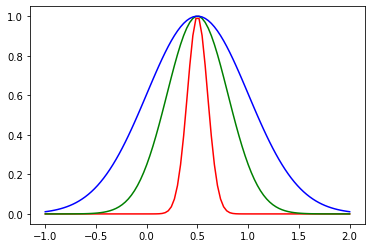

In [25]:
z=np.linspace(-1,2.0,nodes_num)
mu=0.5
sig1=0.1
sig2=0.3
sig3=0.5
y1=np.exp(-0.5*(z-mu)**2/(sig1*sig1))
y2=np.exp(-0.5*(z-mu)**2/(sig2*sig2))
y3=np.exp(-0.5*(z-mu)**2/(sig3*sig3))
plt.plot(z,y1,color="red")
plt.plot(z,y2,color="green")
plt.plot(z,y3,color="blue")
plt.show()

### 近傍半径について
近傍半径･･･各ノードの学習量を決める場合に重要  
- 近傍半径が小さい…ガウス関数は急激に減少.勝者ノードから少し離れたときでも学習量は小さくなる  
- 近傍半径が大きい…ガウス関数はなだらかに減少.勝者ノードから遠くのノードでも学習量は大きい
#### SOMでは学習回数が増えるにつれて近傍半径を小さくする

### 近傍半径の減少を実際に見てみよう

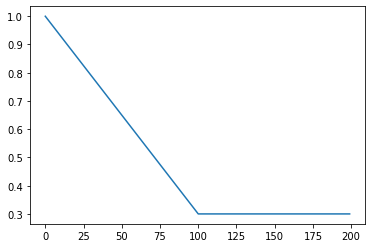

In [26]:
sig_min=0.3#最小近傍半径
sig_max=1#最大近傍半径
T=100
a=np.zeros((200))
for t in range(200):
    a[t]=max((sig_min-sig_max)*t/T+sig_max,sig_min)#max関数･･･2値を比較して大きい値を返す
x=np.arange(200)
plt.plot(x,a)
plt.show()

## 協調過程を実装しよう!!
学習量を求めるプログラムを実装しよう  
必要なもの
- 潜在空間の座標
- 勝者ノードの座標

# Step 3. 適応過程(Adaptive Process)

協調過程で求めた学習量に基づいて参照ベクトルの更新を行います．  
$\mathbf{x}_n=(x_{n1},\dots,x_{nD}),\ \mathbf{y}_k=(y_{k1},\dots,y_{kD})$として，全ての$k$と$d$に関して以下のように更新します．
$$y_{kd}=\sum_{n=1}^N r_{kn} x_{nd}$$
$r_{kn}$は次のように求めます．
$$r_{kn}=\frac{h_{kn}}{g_k}$$
$$g_k=\sum_{n'=1}^Nh_{kn'}$$

### $\sum$ってなんだろう？
例えば$a_1,\dots,a_I$を用いると
$$\sum_{i=1}^I  a_i=a_1+\dots+a_I$$  
$i=1,\dots,I$に関して総和を取ってるんですねぇ〜

さぁ実際に組んでみよう！あと少し！！がんばって(੭ु ›ω‹ )੭ु⁾⁾

### *実践*
協調過程で求めた学習量を用いて$K$個の参照ベクトルを上記の式で更新せよ  
必要なもの  
- 学習量
- 観測データ

# Pycharmで実際に組んでみよう！
演習で組んだ3ステップを参考にしつつ，SOMのアルゴリズムを完成させよう！
実行させるために必要なコードはGitに用意してあります
- ひな形となるソースコード
  - three_months_course_2018/Lecture1/simulation_code_sample/fitting_kura.py
  - pycharmでこれにSOMのアルゴリズム書き込んでください
- 観測データ用ライブラリ
  - three_months_course_2018/libs/datasets/artificial/kura.py
  - 観測データを吐き出してくれる関数が入っています
- 描画用ライブラリ
  - three_months_course_2018/libs/visualization/som/animation_learning_process_3d.py
  - すべての学習回数における参照ベクトル（$TxKxD$の3次元配列）と観測データを放り込むと描画してくれます

# 課題
## 課題1：パラメータを変えた時の結果の変化を見る
双曲面データに関してパラメータを変えてみて，どのような結果が得られたかを報告し，なぜそうなったかを考察せよ
## 課題2：動物データの解析
実装したSOMに動物データを入れてU-matrix表示をcomponent plane表示を行い，どのような結果が得られたかを考察せよ．ソースコードの雛形，動物データ出力ライブラリ，描画用ライブラリについてはgitにあるので分からない時は先輩に聞くこと

# レポート
- SOMの概要
- アルゴリズム
- 双曲面データの実行結果及び考察
- 課題
  - 課題1について結果とその考察
  - 課題2について結果とその考察
